In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [2]:
data_dir = './data/tesseract_output/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, 0.1)
print(trainloader.dataset.classes)

classes = ['0', '4', '6', '8', 'A', 'B', 'O']

['0', '4', '6', '8', 'A', 'B', 'O']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

)


In [4]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
epochs = 100
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device),  labels.to(device)
        print(inputs.shape)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: 0.631.. Test loss: 0.629.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: 0.624.. Test loss: 0.617.. Test accuracy: 0.302
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: 0.018.. Test loss: 0.653.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: -0.149.. Test loss: 0.642.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: 0.683.. Test loss: 0.607.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: -0.492.. Test loss: 0.592.. Test accuracy: 0.302
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: -0.035.. Test loss: 0.638.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: 0.275.. Test loss: 0.776.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: -0.599.. Test loss: 0.615.. Test accuracy: 0.260
torch.Size([16, 3, 224, 224])
Epoch 1/100.. Train loss: -0.8

torch.Size([16, 3, 224, 224])
Epoch 5/100.. Train loss: 0.027.. Test loss: 0.582.. Test accuracy: 0.344
torch.Size([12, 3, 224, 224])
Epoch 5/100.. Train loss: 0.624.. Test loss: 0.604.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: 0.225.. Test loss: 0.666.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: -0.212.. Test loss: 0.657.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: -0.201.. Test loss: 0.651.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: -0.483.. Test loss: 0.551.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: -0.478.. Test loss: 0.600.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: 0.186.. Test loss: 0.551.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: -0.119.. Test loss: 0.531.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 6/100.. Train loss: 0.2

torch.Size([16, 3, 224, 224])
Epoch 10/100.. Train loss: -0.201.. Test loss: 0.588.. Test accuracy: 0.302
torch.Size([16, 3, 224, 224])
Epoch 10/100.. Train loss: -0.100.. Test loss: 0.606.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 10/100.. Train loss: -1.009.. Test loss: 0.633.. Test accuracy: 0.312
torch.Size([12, 3, 224, 224])
Epoch 10/100.. Train loss: -1.139.. Test loss: 0.570.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Train loss: 0.712.. Test loss: 0.564.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Train loss: -1.019.. Test loss: 0.585.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Train loss: -0.312.. Test loss: 0.624.. Test accuracy: 0.302
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Train loss: 0.168.. Test loss: 0.614.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Train loss: 0.729.. Test loss: 0.525.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 11/100.. Trai

Epoch 15/100.. Train loss: -0.522.. Test loss: 0.588.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 15/100.. Train loss: 0.630.. Test loss: 0.502.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 15/100.. Train loss: -1.675.. Test loss: 0.544.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 15/100.. Train loss: -0.610.. Test loss: 0.549.. Test accuracy: 0.292
torch.Size([16, 3, 224, 224])
Epoch 15/100.. Train loss: 0.570.. Test loss: 0.638.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 15/100.. Train loss: -0.140.. Test loss: 0.569.. Test accuracy: 0.344
torch.Size([12, 3, 224, 224])
Epoch 15/100.. Train loss: -0.400.. Test loss: 0.559.. Test accuracy: 0.344
torch.Size([16, 3, 224, 224])
Epoch 16/100.. Train loss: 0.699.. Test loss: 0.591.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 16/100.. Train loss: -0.277.. Test loss: 0.595.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 16/100.. Train loss: -1.235.. Test loss: 0.

Epoch 20/100.. Train loss: -0.080.. Test loss: 0.533.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: -0.197.. Test loss: 0.524.. Test accuracy: 0.292
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: 0.756.. Test loss: 0.652.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: -0.638.. Test loss: 0.554.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: 0.134.. Test loss: 0.475.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: -0.735.. Test loss: 0.592.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: 0.068.. Test loss: 0.660.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: -0.859.. Test loss: 0.565.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 20/100.. Train loss: 0.657.. Test loss: 0.556.. Test accuracy: 0.333
torch.Size([12, 3, 224, 224])
Epoch 20/100.. Train loss: -1.079.. Test loss: 0.5

Epoch 25/100.. Train loss: 0.045.. Test loss: 0.597.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: 0.102.. Test loss: 0.613.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: -0.977.. Test loss: 0.667.. Test accuracy: 0.312
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: -0.927.. Test loss: 0.531.. Test accuracy: 0.344
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: -0.892.. Test loss: 0.641.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: 0.014.. Test loss: 0.613.. Test accuracy: 0.302
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: -1.008.. Test loss: 0.541.. Test accuracy: 0.333
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: -0.139.. Test loss: 0.591.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: 0.140.. Test loss: 0.642.. Test accuracy: 0.323
torch.Size([16, 3, 224, 224])
Epoch 25/100.. Train loss: 0.618.. Test loss: 0.71

KeyboardInterrupt: 

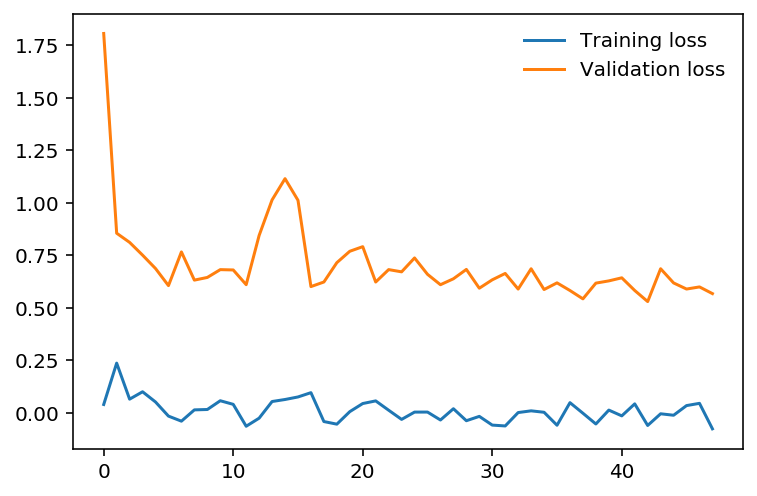

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [7]:
data_dir = './data/tesseract_output/train'
test_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [10]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

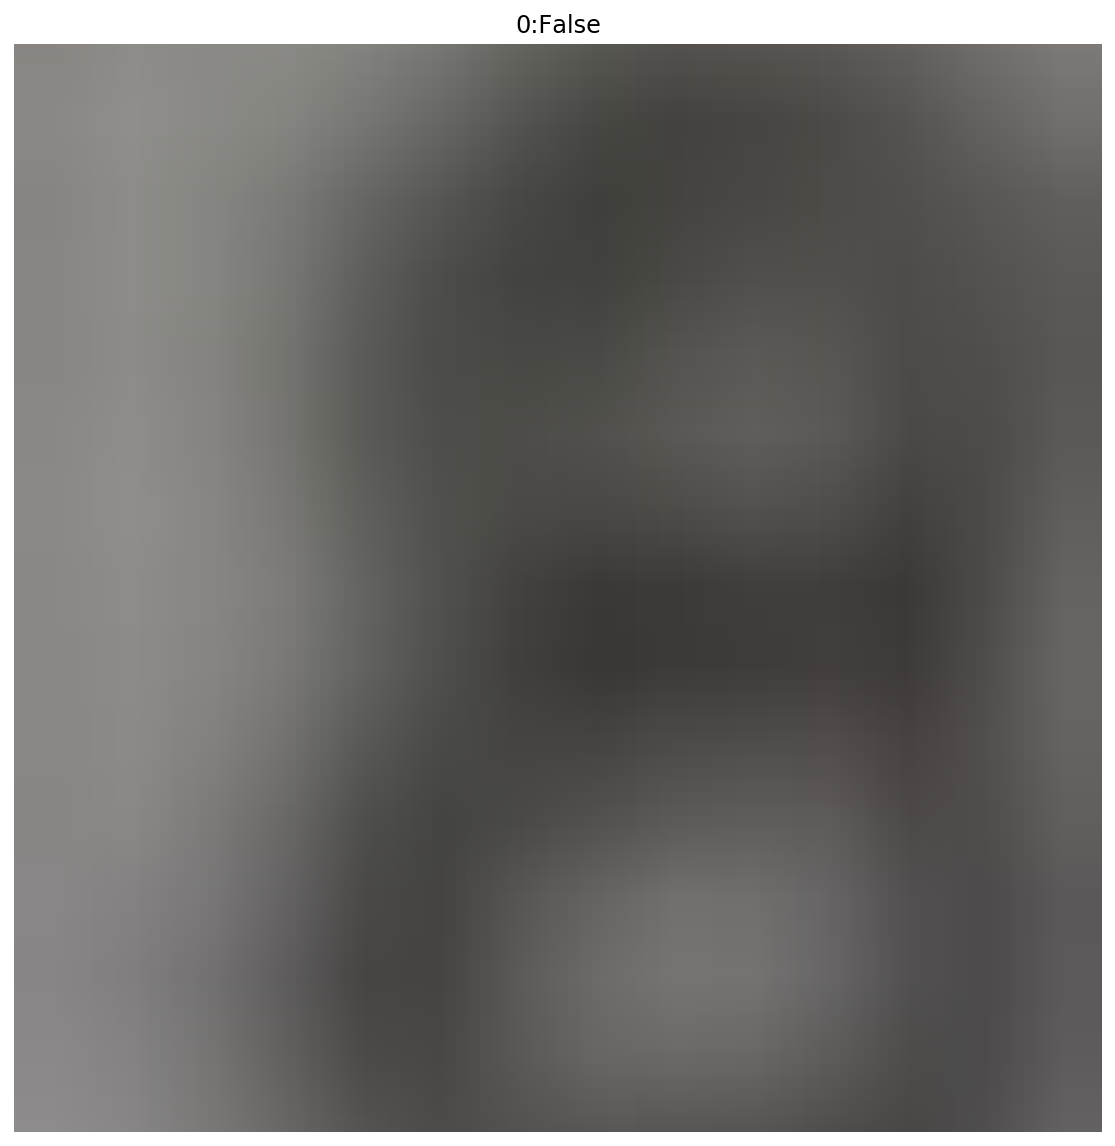

In [11]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(1)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()